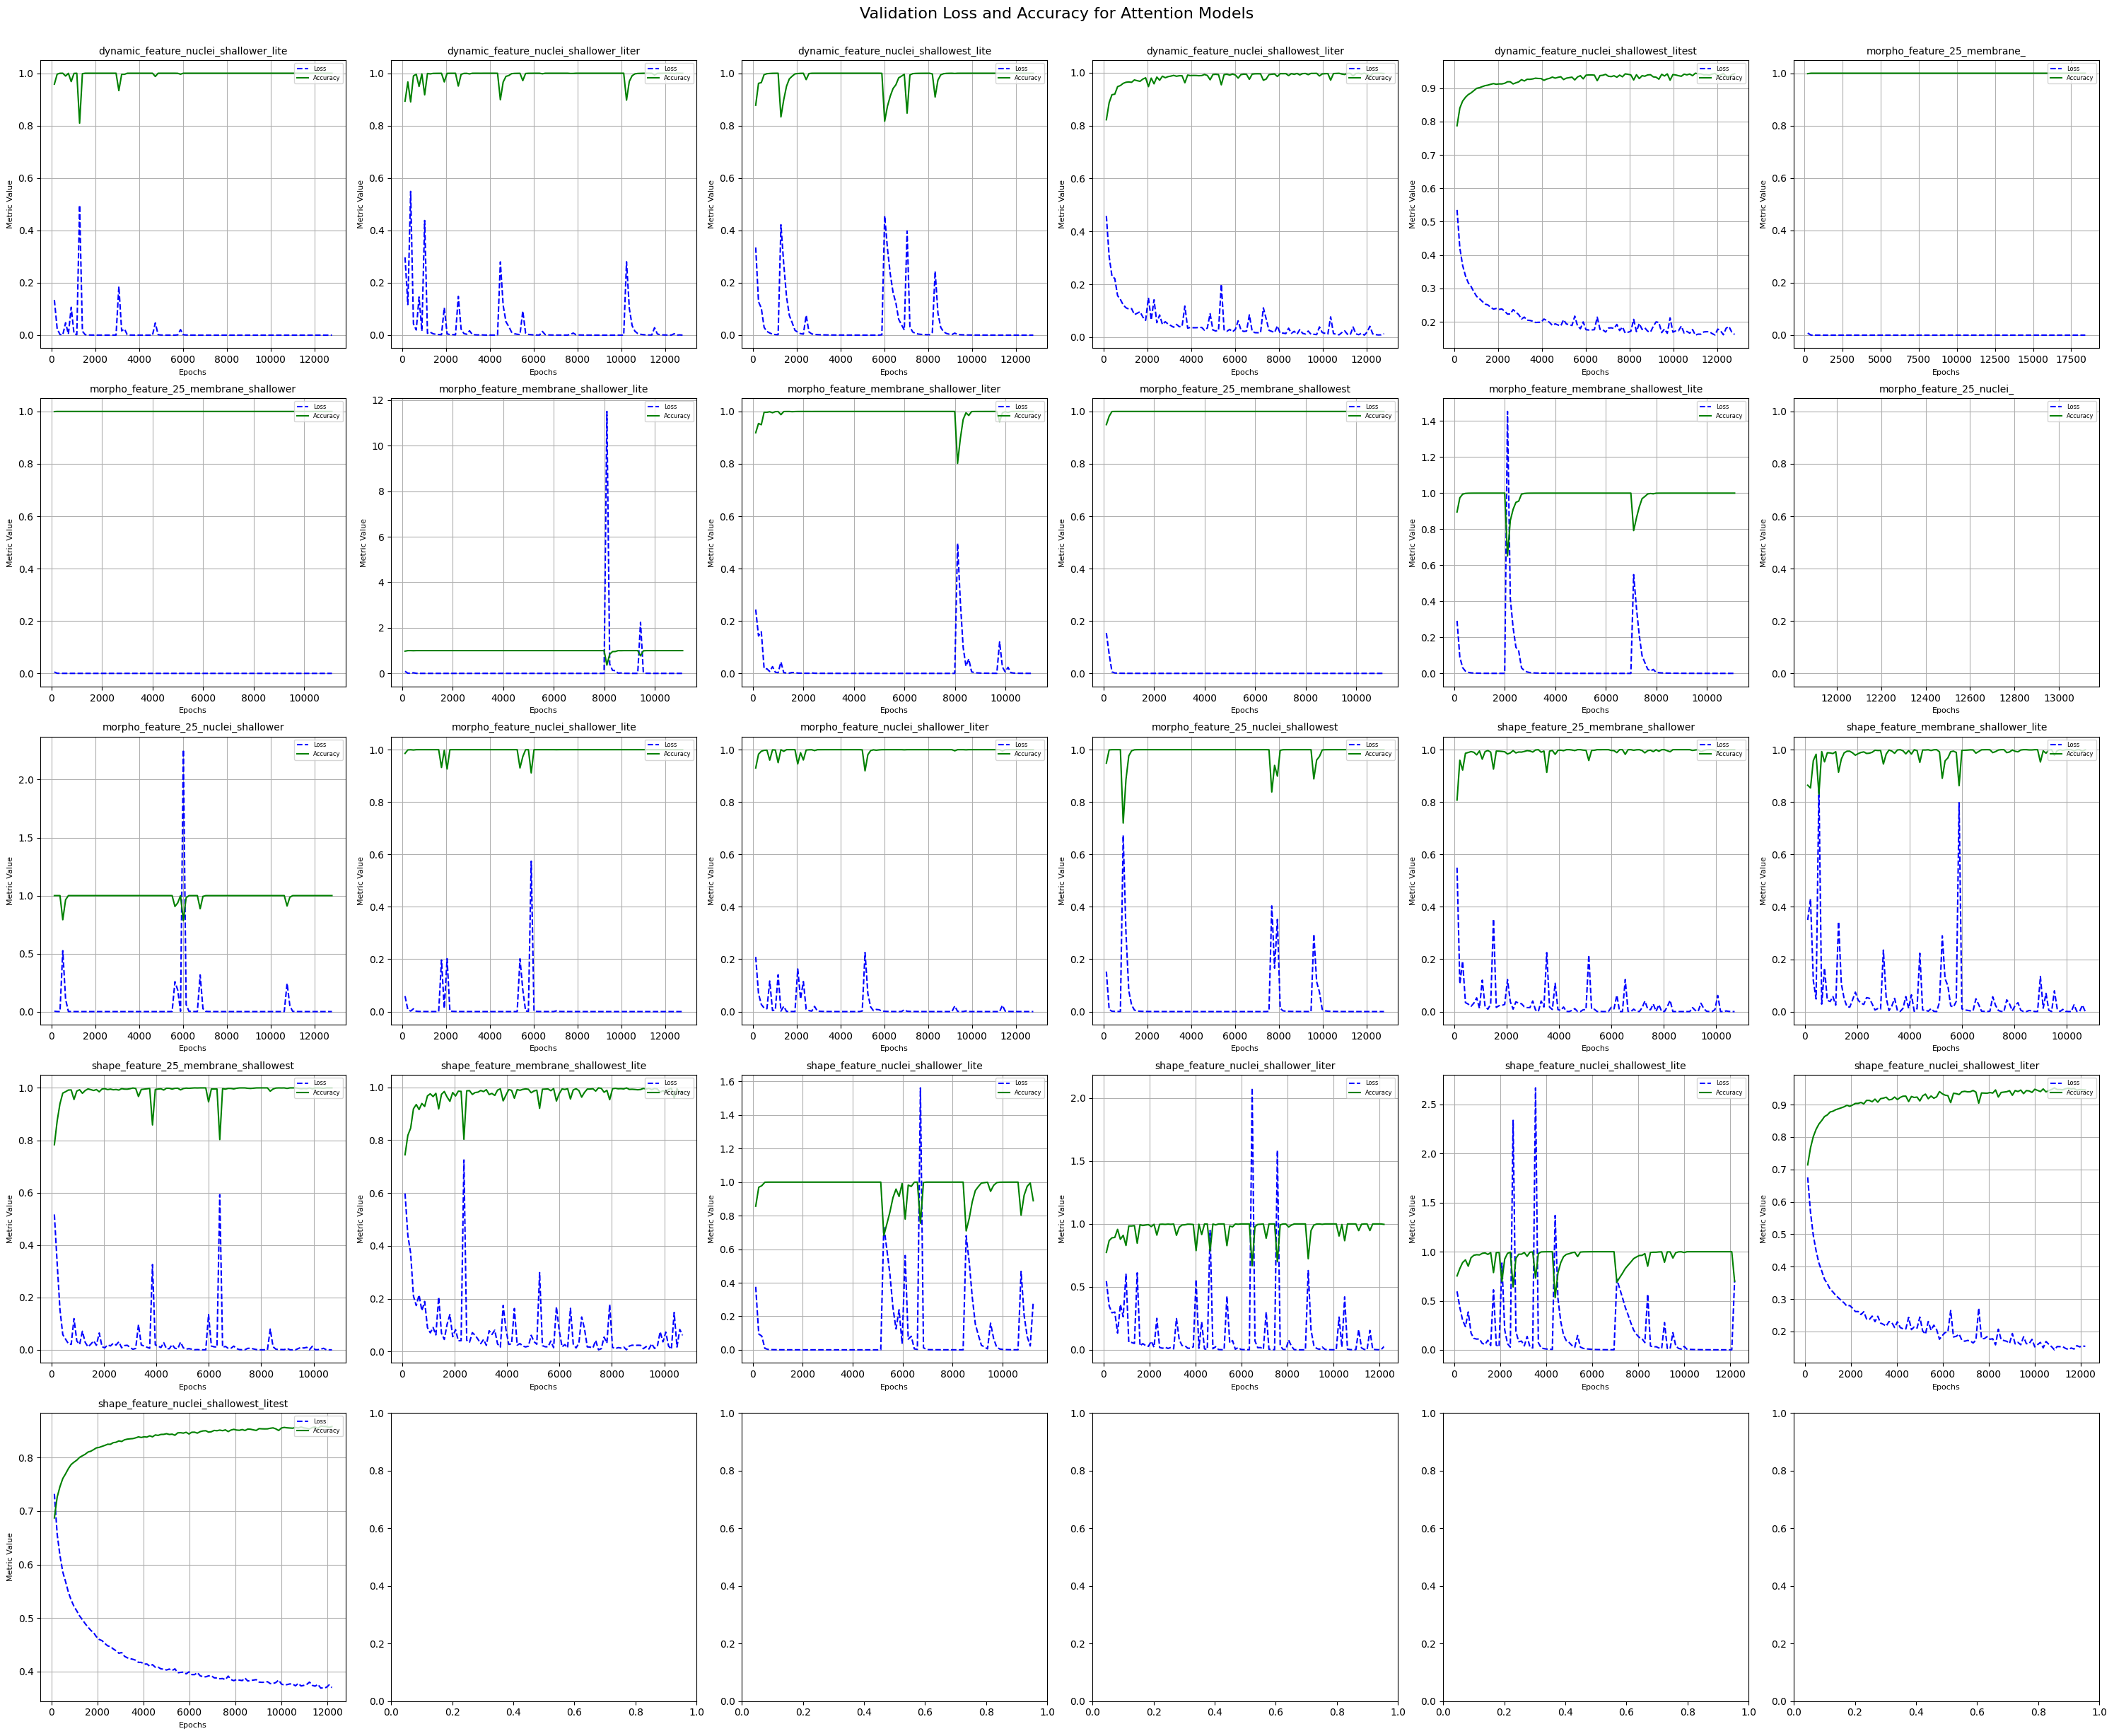

In [16]:


import os
import numpy as np
import matplotlib.pyplot as plt

# Define the directory containing subfolders with npz files
base_dir = '/home/debian/jz/Mari_Models/TrackModels'

# Initialize lists to store data for plotting
validation_loss_data = []
validation_accuracy_data = []
folders = []

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path) and 'attention' in folder:
        # Find the npz file in the directory
        for file in os.listdir(folder_path):
            if file.endswith('.npz'):
                file_path = os.path.join(folder_path, file)
                try:
                    data = np.load(file_path, allow_pickle=True)
                    if 'validation_loss' in data:
                        steps = data['validation_loss'].item().get('steps', [])
                        values = data['validation_loss'].item().get('values', [])
                        if len(steps) == len(values):
                            validation_loss_data.append((steps, values))
                            folders.append(folder)
                    if 'validation_accuracy' in data:
                        acc_steps = data['validation_accuracy'].item().get('steps', [])
                        acc_values = data['validation_accuracy'].item().get('values', [])
                        if len(acc_steps) == len(acc_values):
                            validation_accuracy_data.append((acc_steps, acc_values))
                except Exception as e:
                    print(f'Skipping {folder} {e}') 

# Number of models
num_models = len(folders)

# Define the number of rows and columns for subplots

cols = 6
rows = (num_models  + 1)// cols + 1
fig, axes = plt.subplots(rows, cols, figsize=(30, 25))
axes = axes.flatten()

# Plot each model's validation loss and accuracy
for i, ax in enumerate(axes[:num_models]):
    folder = folders[i]
    posttitle = "_".join(folder.split("_")[-3:])
    title = "_".join(folder.split("_")[:2])
    title += '_' + posttitle
    # Plot validation loss
    steps, values = validation_loss_data[i]
    ax.plot(steps, values, label='Loss', linestyle='--', color='b')

    # Plot validation accuracy if available
    if i < len(validation_accuracy_data):
        acc_steps, acc_values = validation_accuracy_data[i]
        ax.plot(acc_steps, acc_values, label='Accuracy', color='g')

    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Epochs', fontsize=8)
    ax.set_ylabel('Metric Value', fontsize=8)
    ax.legend(loc='upper right', fontsize=6)
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle('Validation Loss and Accuracy for Attention Models', fontsize=16)
plt.show()
